In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from tensorflow.keras.layers import Input, concatenate,Dense
from keras.models import Sequential
from keras.layers import Concatenate, Dense,Input, concatenate
from keras.models import Model    
from keras.layers import Dropout,Flatten


In [3]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.85; # percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #15% for testing:0.15*4000=600

# spatial slicing dimensions
os = 8 # output slice size
halo = 2 # edge cells
ts = os + halo * 2 # total input slice size including halos 12
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 511  # number of slices in one profile 



In [4]:
print(train_size,test_size)

3400 600


In [5]:
#train validation test split -------------------------------------------------


#train set and validation set
train_image=np.zeros((l2r*train_size,ts,3)) # 3400 profiles in train set, includes validation
train_label=np.zeros((l2r*train_size,os)) 
for i in range(511):
#cut each profile into 511 slices. 
#label: tau channel of the center of each slice(reduced domain), they ignore the edge pixel.
    train_img= data[:train_size, i*os:i*os+ts, 0:nchan] #input: first 3400 profiles, 12 pixels for one slice, 3 channels 
    train_lb = data[:train_size, i*os+halo:i*os+halo+os, nchan] #first 3400 profiles, 8 pixels for label,the tau channel is the label
    train_image[i*train_size:i*train_size+train_size]=train_img
    train_label[i*train_size:i*train_size+train_size,:]=train_lb #511*3400=1737400
print('train_image size: ',train_image.shape,'train_label size: ', train_label.shape)



#test set
test_image=np.zeros((l2r*test_size,ts,3)) #600 profiles to test
test_label=np.zeros((l2r*test_size,os)) 
for i in range(511):
    test_img= data[(train_size):num, i*os:i*os+ts, 0:nchan]
    test_lb= data[(train_size):num, i*os+halo:i*os+halo+os, nchan]
    test_image[i*test_size:i*test_size+test_size]=test_img
    test_label[i*test_size:i*test_size+test_size,:]=test_lb #511*600=306600
print('test_image size: ',test_image.shape,'test_label size: ', test_label.shape)


train_image size:  (1737400, 12, 3) train_label size:  (1737400, 8)
test_image size:  (306600, 12, 3) test_label size:  (306600, 8)


In [6]:
predictions = np.empty((test_size,8)) 
predictions.shape

(600, 8)

In [9]:
# DNN over domain -------------------------------------------

input_img = Input(shape=(ts,nchan))
hn=Flatten()(input_img)
hn = Dense(8, activation='relu')(hn)#1st fully connected layer
hn1 =Dense(1024, activation='relu')(hn)
hn1=Dense(1024, activation='relu')(hn1)
hn1=Dropout(0.5)(hn1)
hn1=Dense(8, activation='relu')(hn1) #4th fully connected layer
out_both = concatenate([hn, hn1], axis=1, name = 'concatenate')
hn2=Dense(8, activation='linear')(out_both)
model_m = Model(input_img, outputs=[hn2])
model_m.summary()


ltype = 'mean_squared_error'
ltype2=tf.keras.metrics.RootMeanSquaredError()
bsize = 1024
eps = 500

model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,ltype2])

#earlystopping to find the optimal number of epochs 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience = 25,restore_best_weights = True,
                                           verbose=1) 

history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.17647,
                          callbacks =[earlystopping])#validation set(15%)/trainset(85%)=0.17647

# test and predict ---------------------------------------------
print('test result')

results = model_m.evaluate(test_image, test_label)
predictions=model_m.predict(test_image)

mse = results[0]
rmse=results[2]

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 12, 3)]      0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 36)           0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 8)            296         flatten_2[0][0]                  
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 1024)         9216        dense_10[0][0]                   
____________________________________________________________________________________________

1398/1398 [==============================] - 8s 5ms/step - loss: 14.9816 - mean_squared_error: 14.9816 - root_mean_squared_error: 3.8704 - val_loss: 14.8210 - val_mean_squared_error: 14.8210 - val_root_mean_squared_error: 3.8498
Epoch 26/500
1398/1398 [==============================] - 8s 5ms/step - loss: 14.8359 - mean_squared_error: 14.8359 - root_mean_squared_error: 3.8515 - val_loss: 15.8461 - val_mean_squared_error: 15.8461 - val_root_mean_squared_error: 3.9807
Epoch 27/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.9567 - mean_squared_error: 14.9567 - root_mean_squared_error: 3.8669 - val_loss: 15.2311 - val_mean_squared_error: 15.2311 - val_root_mean_squared_error: 3.9027
Epoch 28/500
1398/1398 [==============================] - 7s 5ms/step - loss: 14.7724 - mean_squared_error: 14.7724 - root_mean_squared_error: 3.8431 - val_loss: 14.6889 - val_mean_squared_error: 14.6889 - val_root_mean_squared_error: 3.8326
Epoch 29/500
1398/1398 [=====================

Epoch 59/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.7061 - mean_squared_error: 13.7061 - root_mean_squared_error: 3.7020 - val_loss: 13.9246 - val_mean_squared_error: 13.9246 - val_root_mean_squared_error: 3.7316
Epoch 60/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.8592 - mean_squared_error: 13.8592 - root_mean_squared_error: 3.7226 - val_loss: 13.6618 - val_mean_squared_error: 13.6618 - val_root_mean_squared_error: 3.6962
Epoch 61/500
1398/1398 [==============================] - 7s 5ms/step - loss: 13.7369 - mean_squared_error: 13.7369 - root_mean_squared_error: 3.7063 - val_loss: 13.7197 - val_mean_squared_error: 13.7197 - val_root_mean_squared_error: 3.7040
Epoch 62/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.5541 - mean_squared_error: 13.5541 - root_mean_squared_error: 3.6814 - val_loss: 15.8837 - val_mean_squared_error: 15.8837 - val_root_mean_squared_error: 3.9854
Epoch 63/500
1398/1398 [========

Epoch 93/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.9187 - mean_squared_error: 12.9187 - root_mean_squared_error: 3.5939 - val_loss: 13.1746 - val_mean_squared_error: 13.1746 - val_root_mean_squared_error: 3.6297
Epoch 94/500
1398/1398 [==============================] - 8s 6ms/step - loss: 13.0021 - mean_squared_error: 13.0021 - root_mean_squared_error: 3.6058 - val_loss: 13.2894 - val_mean_squared_error: 13.2894 - val_root_mean_squared_error: 3.6455
Epoch 95/500
1398/1398 [==============================] - 8s 5ms/step - loss: 13.0686 - mean_squared_error: 13.0686 - root_mean_squared_error: 3.6150 - val_loss: 12.8487 - val_mean_squared_error: 12.8487 - val_root_mean_squared_error: 3.5845
Epoch 96/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.9149 - mean_squared_error: 12.9149 - root_mean_squared_error: 3.5936 - val_loss: 13.1341 - val_mean_squared_error: 13.1341 - val_root_mean_squared_error: 3.6241
Epoch 97/500
1398/1398 [========

Epoch 127/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.6233 - mean_squared_error: 12.6233 - root_mean_squared_error: 3.5527 - val_loss: 13.5917 - val_mean_squared_error: 13.5917 - val_root_mean_squared_error: 3.6867
Epoch 128/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.6867 - mean_squared_error: 12.6867 - root_mean_squared_error: 3.5617 - val_loss: 13.1508 - val_mean_squared_error: 13.1508 - val_root_mean_squared_error: 3.6264
Epoch 129/500
1398/1398 [==============================] - 7s 5ms/step - loss: 12.6524 - mean_squared_error: 12.6524 - root_mean_squared_error: 3.5569 - val_loss: 13.2024 - val_mean_squared_error: 13.2024 - val_root_mean_squared_error: 3.6335
Epoch 130/500
1398/1398 [==============================] - 8s 5ms/step - loss: 12.7987 - mean_squared_error: 12.7987 - root_mean_squared_error: 3.5772 - val_loss: 14.4761 - val_mean_squared_error: 14.4761 - val_root_mean_squared_error: 3.8047
Epoch 131/500
1398/1398 [===

In [10]:
predictions.shape

(306600, 8)

The optimal number of epochs is 121


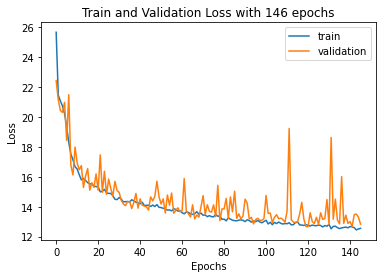

In [12]:
patience=25
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('DNN-2r train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [13]:
#quantitative reuslt: mean square error on testset
mse  

11.100492477416992

In [14]:
rmse

3.331740140914917

In [15]:
predict1=np.zeros((511,8))
for i in range(511):
    predict1[i]=predictions[i*test_size+test_size-3]
    
predict2=np.zeros((511,8))
for i in range(511):
    predict2[i]=predictions[i*test_size+test_size-2]
    
predict3=np.zeros((511,8))
for i in range(511):
    predict3[i]=predictions[i*test_size+test_size-1]

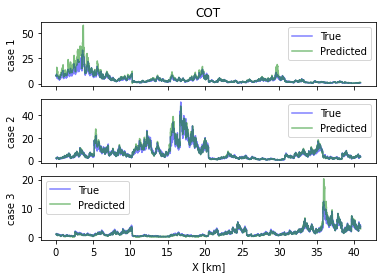

In [17]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+'DNN-2r Connection'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo],data[num-3,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict1.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo],data[num-2,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict2.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo],data[num-1,halo:os*l2r+halo,3].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo],predict3.reshape(4088),alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')




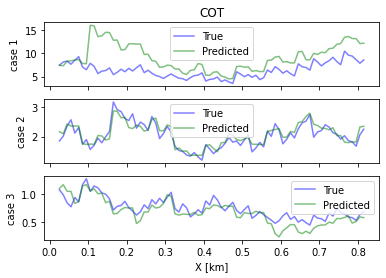

In [19]:
# plotting ------------------------------------------------------
fgnm = "predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_pixels_DNN-2r Connection"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"COT")
ax.plot(x[halo:os*l2r+halo][:80],data[num-3,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict1.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[halo:os*l2r+halo][:80],data[num-2,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[halo:os*l2r+halo][:80],predict2.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[halo:os*l2r+halo][:80],data[num-1,halo:os*l2r+halo,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[halo:os*l2r+halo][:80],predict3.reshape(4088)[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')